In [717]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [718]:
m = 50          # 5, 50, 100, 500, 2000

In [719]:
train_size = 500          # 100, 500, 2000, 10000

# Generate dataset

In [720]:
np.random.seed(12)
y = np.random.randint(0,10,5000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 530
1 463
2 494
3 517
4 488
5 497
6 493
7 507
8 492
9 519


In [721]:
x = np.zeros((5000,2))

In [722]:
np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [7,4],cov=[[0.1,0],[0,0.1]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [8,6.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [5.5,6.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [-1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [0,2],cov=[[0.1,0],[0,0.1]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [0,-1],cov=[[0.1,0],[0,0.1]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [0,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [-0.5,-0.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [0.4,0.2],cov=[[0.1,0],[0,0.1]],size=sum(idx[9]))

In [723]:
x[idx[0]][0], x[idx[5]][5] 

(array([7.14957125, 3.78451422]), array([0.87756167, 0.00457805]))

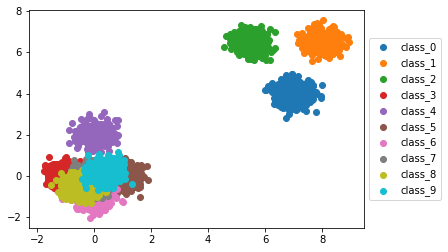

In [724]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [725]:
bg_idx = [ np.where(idx[3] == True)[0], 
          np.where(idx[4] == True)[0], 
          np.where(idx[5] == True)[0],
          np.where(idx[6] == True)[0], 
          np.where(idx[7] == True)[0], 
          np.where(idx[8] == True)[0],
          np.where(idx[9] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
bg_idx.shape

(3513,)

In [726]:
np.unique(bg_idx).shape

(3513,)

In [727]:
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)


In [728]:
np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

(array([[-1.04275003e-16,  6.74571889e-17]]),
 array([[2.02981967, 1.63582644]]))

In [729]:
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [730]:
np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

(array([[1., 1.]]), array([[4.89756643, 3.00501566]]))

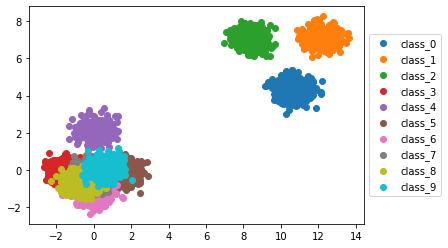

In [731]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [732]:
foreground_classes = {'class_0','class_1', 'class_2'}

background_classes = {'class_3','class_4', 'class_5', 'class_6','class_7', 'class_8', 'class_9'}

In [733]:
fg_class  = np.random.randint(0,3)
fg_idx = np.random.randint(0,m)
train_data=[]
a = []
fg_instance = np.array([[0.0,0.0]])
bg_instance = np.array([[0.0,0.0]])

for i in range(m):
  if i == fg_idx:
    b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
    fg_instance += x[b]
    a.append(x[b])
    print("foreground "+str(fg_class)+" present at " + str(fg_idx))
  else:
    bg_class = np.random.randint(3,10)
    b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
    bg_instance += x[b]
    a.append(x[b])
    print("background "+str(bg_class)+" present at " + str(i))

a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 3 present at 0
background 8 present at 1
background 5 present at 2
background 3 present at 3
background 5 present at 4
background 7 present at 5
background 6 present at 6
background 5 present at 7
background 3 present at 8
background 5 present at 9
background 4 present at 10
background 7 present at 11
background 4 present at 12
background 3 present at 13
background 9 present at 14
background 6 present at 15
background 6 present at 16
background 3 present at 17
foreground 2 present at 18
background 8 present at 19
background 5 present at 20
background 6 present at 21
background 4 present at 22
background 9 present at 23
background 8 present at 24
background 3 present at 25
background 7 present at 26
background 6 present at 27
background 8 present at 28
background 3 present at 29
background 7 present at 30
background 8 present at 31
background 7 present at 32
background 7 present at 33
background 5 present at 34
background 9 present at 35
background 6 present at 36
background 

In [734]:
a

array([[-1.62273068e+00, -9.44577073e-01],
       [-8.22962717e-01, -7.32521912e-01],
       [ 2.09728368e+00, -2.44651323e-01],
       [-9.86087689e-01, -7.51232458e-01],
       [ 1.37297554e+00, -3.76733075e-01],
       [-8.84692079e-01, -1.11551995e-01],
       [ 3.23086410e-01, -1.23774128e+00],
       [ 1.37297554e+00, -3.76733075e-01],
       [-1.37994224e+00, -1.86927689e-02],
       [ 1.18729176e+00, -1.43385686e-01],
       [ 1.08414750e+00,  2.21424613e+00],
       [ 3.07773579e-01,  5.11134472e-01],
       [-5.80062748e-01,  2.56861924e+00],
       [-1.57480355e+00,  1.37864198e-01],
       [ 8.78834768e-01, -3.18178197e-01],
       [ 5.58625839e-02, -1.37825691e+00],
       [ 3.52658712e-01, -1.71500720e+00],
       [-7.59374170e-01, -4.37189615e-03],
       [ 8.64012267e+00,  7.37468589e+00],
       [-9.53821465e-01, -7.70258879e-01],
       [ 2.09867980e+00, -3.81343563e-01],
       [-5.28144052e-02, -1.09369602e+00],
       [ 5.77182460e-01,  2.12761839e+00],
       [ 4.

In [735]:
fg_instance

array([[8.64012267, 7.37468589]])

In [736]:
bg_instance

array([[-1.74857013, -7.93565902]])

In [737]:
(fg_instance+bg_instance)/m , m

(array([[ 0.13783105, -0.01121946]]), 50)

In [738]:
# mosaic_list_of_images =[]
# mosaic_label = []
train_label=[]
fore_idx=[]
train_data = []
for j in range(train_size):
  np.random.seed(j)
  fg_instance = torch.zeros([2], dtype=torch.float64) #np.array([[0.0,0.0]])
  bg_instance = torch.zeros([2], dtype=torch.float64) #np.array([[0.0,0.0]])
  # a=[]

  for i in range(m):
    if i == fg_idx:
      fg_class  = np.random.randint(0,3)
      b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
      fg_instance += x[b]
      # a.append(x[b])
      # print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
      bg_class = np.random.randint(3,10)
      b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
      bg_instance += x[b]
      # a.append(x[b])
      # print("background "+str(bg_class)+" present at " + str(i))
  train_data.append((fg_instance+bg_instance)/m)
  # a = np.concatenate(a,axis=0)
  # mosaic_list_of_images.append(np.reshape(a,(2*m,1)))
  train_label.append(fg_class)
  fore_idx.append(fg_idx)

In [739]:
 train_data[0], train_label[0]

(tensor([[0.1418, 0.0205]], dtype=torch.float64), 1)

In [740]:
train_data = torch.stack(train_data, axis=0)
train_data.shape, len(train_label)

(torch.Size([500, 1, 2]), 500)

In [741]:
test_label=[]
# fore_idx=[]
test_data = []
for j in range(1000):
  np.random.seed(j)
  fg_instance = torch.zeros([2], dtype=torch.float64) #np.array([[0.0,0.0]])

  fg_class  = np.random.randint(0,3)
  b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
  fg_instance += x[b]
  # a.append(x[b])
  # print("foreground "+str(fg_class)+" present at " + str(fg_idx))

  test_data.append((fg_instance)/m)
  # a = np.concatenate(a,axis=0)
  # mosaic_list_of_images.append(np.reshape(a,(2*m,1)))
  test_label.append(fg_class)
  # fore_idx.append(fg_idx)

In [742]:
test_data[0], test_label[0]

(tensor([[0.2228, 0.0783]], dtype=torch.float64), 0)

In [743]:
test_data = torch.stack(test_data, axis=0)
test_data.shape, len(test_label)

(torch.Size([1000, 1, 2]), 1000)

In [744]:
x1 = (train_data).numpy()
y1 = np.array(train_label)

In [745]:
x1[y1==0,0]

array([[ 0.14802493,  0.12159511],
       [ 0.22062182,  0.17157012],
       [ 0.32615974, -0.19070888],
       [ 0.14885966, -0.01851265],
       [ 0.26144447,  0.22297099],
       [ 0.15414395, -0.05440411],
       [ 0.08951863, -0.04422909],
       [ 0.16342432,  0.16816626],
       [ 0.24186954,  0.11480108],
       [ 0.321191  ,  0.11851096],
       [ 0.47454428, -0.10787294],
       [ 0.34437747,  0.02949319],
       [ 0.12597701, -0.0655565 ],
       [ 0.31273059,  0.02779416],
       [ 0.07947895,  0.38330684],
       [ 0.22548846, -0.18763613],
       [ 0.14002299, -0.21598621],
       [ 0.19000603,  0.14317529],
       [ 0.0629717 ,  0.04005631],
       [ 0.15986864,  0.12821094],
       [ 0.15957045,  0.06312973],
       [ 0.30925592,  0.06775632],
       [ 0.40003877, -0.07715829],
       [ 0.30708946,  0.13575478],
       [ 0.12339418,  0.06395791],
       [ 0.46107582, -0.05141227],
       [ 0.08929819,  0.26098709],
       [ 0.11702954,  0.37159822],
       [ 0.42103238,

In [746]:
x1[y1==0,0][:,0]

array([ 0.14802493,  0.22062182,  0.32615974,  0.14885966,  0.26144447,
        0.15414395,  0.08951863,  0.16342432,  0.24186954,  0.321191  ,
        0.47454428,  0.34437747,  0.12597701,  0.31273059,  0.07947895,
        0.22548846,  0.14002299,  0.19000603,  0.0629717 ,  0.15986864,
        0.15957045,  0.30925592,  0.40003877,  0.30708946,  0.12339418,
        0.46107582,  0.08929819,  0.11702954,  0.42103238,  0.25771876,
        0.2951142 ,  0.31501513,  0.04985183,  0.08053236,  0.28860669,
        0.22701486,  0.40203713,  0.29663311,  0.38449039,  0.17167951,
        0.08410993,  0.17528099,  0.0137615 ,  0.18963397,  0.30606691,
        0.15932264,  0.19474939,  0.23343142, -0.00126629,  0.33420622,
        0.50069665,  0.34952981,  0.07493225,  0.36382143,  0.07016631,
        0.18611562,  0.26113174,  0.05780559,  0.36045435,  0.29215784,
        0.21972916,  0.10939119,  0.38100389,  0.10577383,  0.13163977,
        0.31877651,  0.21361892,  0.14204714,  0.09964129,  0.36

In [747]:
x1[y1==0,0][:,1]

array([ 0.12159511,  0.17157012, -0.19070888, -0.01851265,  0.22297099,
       -0.05440411, -0.04422909,  0.16816626,  0.11480108,  0.11851096,
       -0.10787294,  0.02949319, -0.0655565 ,  0.02779416,  0.38330684,
       -0.18763613, -0.21598621,  0.14317529,  0.04005631,  0.12821094,
        0.06312973,  0.06775632, -0.07715829,  0.13575478,  0.06395791,
       -0.05141227,  0.26098709,  0.37159822,  0.1960462 ,  0.13210514,
        0.14581188,  0.0577614 ,  0.10094405,  0.09094243,  0.29386769,
        0.17261831,  0.27038283,  0.08845297,  0.36522632,  0.19346745,
       -0.21150071, -0.04564651,  0.11354105,  0.06683694,  0.10816348,
        0.04739749, -0.12377808, -0.0244081 ,  0.24216694,  0.18913132,
        0.00609708,  0.09461631, -0.01014807,  0.17073884,  0.09515718,
        0.07993935,  0.30564142, -0.01675966,  0.32940216,  0.07781552,
        0.1243592 ,  0.03227037,  0.11420482,  0.19886402,  0.03656474,
        0.5459966 ,  0.19617846,  0.00728208,  0.44056396,  0.01

Text(0.5, 1.0, 'dataset4 CIN with alpha = 1/50')

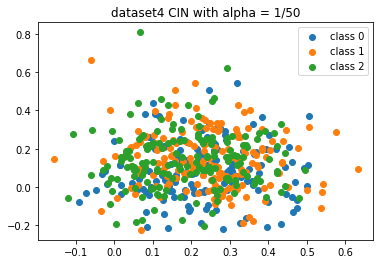

In [748]:
x1 = (train_data).numpy()
y1 = np.array(train_label)

plt.scatter(x1[y1==0,0][:,0], x1[y1==0,0][:,1], label='class 0')
plt.scatter(x1[y1==1,0][:,0], x1[y1==1,0][:,1], label='class 1')
plt.scatter(x1[y1==2,0][:,0], x1[y1==2,0][:,1], label='class 2')
plt.legend()
plt.title("dataset4 CIN with alpha = 1/"+str(m))

Text(0.5, 1.0, 'test dataset4')

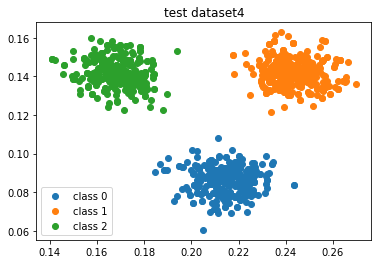

In [749]:
x1 = (test_data).numpy()
y1 = np.array(test_label)

plt.scatter(x1[y1==0,0][:,0], x1[y1==0,0][:,1], label='class 0')
plt.scatter(x1[y1==1,0][:,0], x1[y1==1,0][:,1], label='class 1')
plt.scatter(x1[y1==2,0][:,0], x1[y1==2,0][:,1], label='class 2')
plt.legend()
plt.title("test dataset4")

In [750]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]



In [751]:
train_data[0].shape, train_data[0]

(torch.Size([1, 2]), tensor([[0.1418, 0.0205]], dtype=torch.float64))

In [752]:
batch = 200

traindata_1 = MosaicDataset(train_data, train_label )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)


In [753]:
testdata_1 = MosaicDataset(test_data, test_label )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)


In [754]:
# testdata_11 = MosaicDataset(test_dataset, labels )
# testloader_11 = DataLoader( testdata_11 , batch_size= batch ,shuffle=False)

In [755]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(2,50)
        self.linear2 = nn.Linear(50,3)

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.zeros_(self.linear1.bias)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.zeros_(self.linear2.bias)

    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = (self.linear2(x))

        return x[:,0]

In [756]:
def calculate_loss(dataloader,model,criter):
  model.eval()
  r_loss = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      outputs = model(inputs)
      # print(outputs.shape)
      loss = criter(outputs, labels)
      r_loss += loss.item()
  return r_loss/(i+1)

In [757]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    out = []
    pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to("cuda"),labels.to("cuda")
            out.append(labels.cpu().numpy())
            outputs= net(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    pred = np.concatenate(pred, axis = 0)
    out = np.concatenate(out, axis = 0)
    print("unique out: ",  np.unique(out), "unique pred: ", np.unique(pred) )
    print("correct: ", correct, "total ",  total)
    print('Accuracy of the network on the %d test dataset %d: %.2f %%' % (total, number , 100 * correct / total))

In [758]:
def train_all(trainloader, ds_number, testloader_list, lr_list):
  
  final_loss = []
  for LR in lr_list:    
    print("--"*20, "Learning Rate used is", LR)
    
    torch.manual_seed(12)
    net = Whatnet().double()
    net = net.to("cuda")
    
    criterion_net = nn.CrossEntropyLoss()
    optimizer_net = optim.Adam(net.parameters(), lr=0.001 ) #, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 1000
    running_loss = calculate_loss(trainloader,net,criterion_net)
    loss_curi.append(running_loss)
    print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to("cuda"),labels.to("cuda")

            # zero the parameter gradients
            optimizer_net.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            # print(outputs.shape)
            loss = criterion_net(outputs, labels)
            # print statistics
            running_loss += loss.item()
            loss.backward()
            optimizer_net.step()

        running_loss = calculate_loss(trainloader,net,criterion_net)
        if(epoch%200 == 0):
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss)) 
        loss_curi.append(running_loss)   #loss per epoch
        if running_loss<=0.05:
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss))
          break

    print('Finished Training')
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d train images: %.2f %%' % (total,  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    final_loss.append(loss_curi) 
  return final_loss
    

In [759]:
train_loss_all=[]

testloader_list= [ testloader_1]
lr_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5 ]

In [760]:
fin_loss = train_all(trainloader_1, 1, testloader_list, lr_list)
train_loss_all.append(fin_loss)

---------------------------------------- Learning Rate used is 0.0001
epoch: [0 ] loss: 1.095
epoch: [1] loss: 1.094
epoch: [201] loss: 1.063
epoch: [401] loss: 1.062
epoch: [601] loss: 1.059
epoch: [801] loss: 1.052
Finished Training
Accuracy of the network on the 500 train images: 41.80 %
unique out:  [0 1 2] unique pred:  [1 2]
correct:  515 total  1000
Accuracy of the network on the 1000 test dataset 1: 51.50 %
--------------------------------------------------------------------------------
---------------------------------------- Learning Rate used is 0.0005
epoch: [0 ] loss: 1.095
epoch: [1] loss: 1.094
epoch: [201] loss: 1.063
epoch: [401] loss: 1.062
epoch: [601] loss: 1.059
epoch: [801] loss: 1.052
Finished Training
Accuracy of the network on the 500 train images: 41.80 %
unique out:  [0 1 2] unique pred:  [1 2]
correct:  515 total  1000
Accuracy of the network on the 1000 test dataset 1: 51.50 %
--------------------------------------------------------------------------------


In [761]:
%matplotlib inline

In [762]:
len(fin_loss)

8

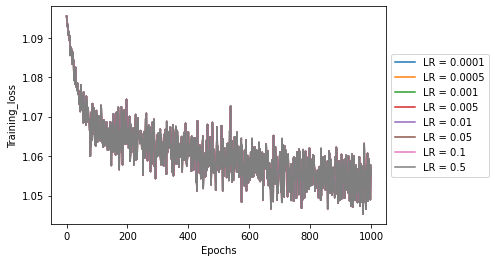

In [763]:
for i,j in enumerate(fin_loss):
    plt.plot(j,label ="LR = "+str(lr_list[i]))
    

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))